# Using LSTM to predict stock market

## Idea: 
The idea is we will use an LSTM model to look at how the trend of the stock go. However, since stock price is also affected by inflation, using pure stock price will make us have to use normalization. Problem is: It's hard to predict future stock price since the price will keep increasing. Instead, we will predict the return of interest that is the percentage of different of the next day compare to current day.


## Import libraries

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import *
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.losses import *

## Data downloading
In this experiment, I will use data from MSFT stock price. A little bit of clean up, I will drop 4 columns which is Dividends, Stock Splits, Volume, and Date since they don't have much relationship with the stock price.     

Stock price we have are Open, High, Low, and Close, which are the price when market open, highest price, lowest price, and price when market close.

In [2]:
msft = yf.Ticker("MSFT")
data = msft.history(interval="1d", period="max")
data = data.reset_index()
data = data.drop(["Dividends", "Stock Splits", "Volume", "Date"], axis=1)
data.head()

,Open,High,Low,Close
0,0.054693,0.062736,0.054693,0.060055
1,0.060055,0.063272,0.060055,0.062199
2,0.062199,0.063808,0.062199,0.063272
3,0.063272,0.063808,0.061127,0.061663
4,0.061663,0.062199,0.060055,0.060591


In [3]:
len(data)

9641

## Convert data to numpy and calculate the return of interest

In [4]:
data = data.to_numpy()

n = data.shape[0]
shape = data.shape
t_data = np.zeros((shape[0] - 1, shape[1]))

for i in range(n-1):
    t_data[i] = (data[i+1] - data[i]) / data[i]

## Preprocessing
In the code below, I will first create how the data structure would look like. We will have the return of interest data of 30 days, and then we will predict the return of interest of the 31st day. Which mean the x-vector is a vector of size 30, and the y is just a scalar number.

I also convert the data type to float32 at the end of this code

In [5]:
n_window = 30

x = np.zeros((9641-30, 30, 4))
y = np.zeros((9641-30, 4))

for i in range(t_data[:,0].shape[0] - 31):
    x[i] = t_data[i:i+30,:]
    y[i] = t_data[i+30,:]

x = x.astype("float32")
y = y.astype("float32")

## Train and Test sets
In here, we will seperate the training and testing data. The training data is the first 9000 records, while the test data is the remaining.

In [6]:
x_train = x[0:9000]
y_train = y[0:9000]

x_test = x[9000:]
y_test = y[9000:]

print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (9000, 30, 4)
Y train: (9000, 4)
X test: (611, 30, 4)
Y test: (611, 4)


In [7]:
len(x)

9611

## Model
The model will just be a very simple one. It has 2 LSTM layers, which will output to a Dense layer of 25 nodes and then a Dense layer of 4 nodes.   

The first two LSTM layers are used to capture the trend and movement of the return interest data. The two Dense layers is just the final calculation of weighting features that is output from LSTM layers. The final Dense of 4 layer is to predict the return interest of the 4 type of price mention above.

In [8]:
model = tf.keras.models.Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 4)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(4))

In [9]:
model.compile(optimizer="adam", loss=MeanSquaredError())
model.fit(x_train, y_train, epochs=10, batch_size=64)


Epoch 1/10

141/141 [==============================] - 11s 35ms/step - loss: 4.1030e-04
Epoch 2/10
141/141 [==============================] - 5s 35ms/step - loss: 3.4542e-04
Epoch 3/10
141/141 [==============================] - 5s 35ms/step - loss: 2.9373e-04
Epoch 4/10
141/141 [==============================] - 5s 35ms/step - loss: 2.8997e-04
Epoch 5/10
141/141 [==============================] - 5s 36ms/step - loss: 2.8587e-04
Epoch 6/10
141/141 [==============================] - 5s 35ms/step - loss: 2.8184e-04
Epoch 7/10
141/141 [==============================] - 5s 35ms/step - loss: 2.7861e-04
Epoch 8/10
141/141 [==============================] - 5s 35ms/step - loss: 2.7725e-04
Epoch 9/10
141/141 [==============================] - 5s 35ms/step - loss: 2.7475e-04
Epoch 10/10
141/141 [==============================] - 5s 35ms/step - loss: 2.7458e-04


## Prediction:
In here is the final result to see how well the model perform

In [10]:
y_pred = model.predict(x_test)

20/20 [==============================] - 1s 11ms/step


### A graph of prediction of return interest of Open price compare to actual one

As we can see from the graph the model doesn't capture perfectly the actual values, however, it can manage to capture the movement of the return interest. You can see when the actual return interest goes up the prediction is also goes up correctly not with the same amount.

This is good because we don't want the model to be overfitted, which mean it predict to close to how the value should be, just the right amount.

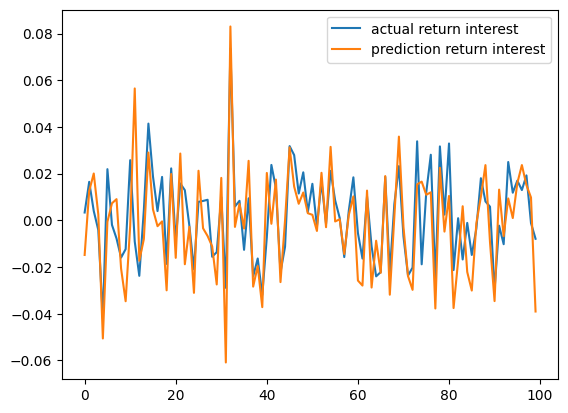

In [11]:
plt.plot(y_pred[0:100,0])
plt.plot(y_test[0:100,0])
plt.legend(['actual return interest', 'prediction return interest'])
plt.show()

### Mean Squared Error

This value means on average how much error we can have in this model for each prediction. With the mean squared error of 0.00023 we can conclude that the error is not too high, and the model is reliable.

In [12]:
mse = tf.keras.losses.MeanSquaredError()
mse(y_test, y_pred).numpy()

0.00022163763

### Showcase reverse prediction of stock price

Now we already have the prediction of return interest of the next day base on 30 days interval. How do we predict the actual stock price?

Well, we just need to do reverse calculation of it to get the predict stock price, The formula is as below:    
`predicted stock price = current stock price * (1 + predicted return interest)`

In [13]:
p_shape = y_pred.shape
price_pred = data[-p_shape[0]:,0] + y_pred[:,0] * data[-p_shape[0]:,0]

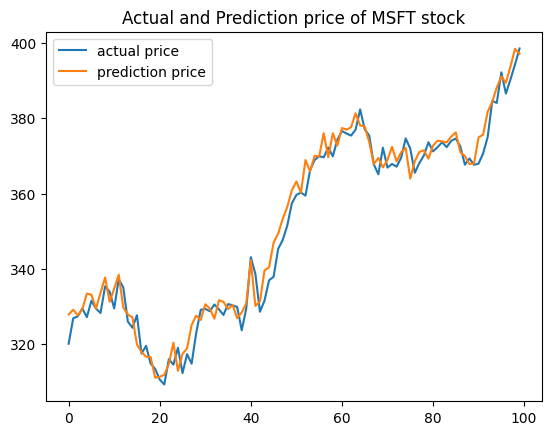

In [14]:
plt.plot(data[-200:-100,0])
plt.plot(price_pred[-200:-100])
plt.legend(['actual price', 'prediction price'])
plt.title("Actual and Prediction price of MSFT stock")
plt.show()